In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

from scipy.stats import mode
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """Оценка качества модели и график preds vs true"""
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
         
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

## Загрузка данных

**Описание датасета**

Статистические данные о ряде домов в России.

* **Id** - идентификационный номер квартиры.
* **DistrictId** - Идентификационный номер района.
* **Rooms** - Количество комнат.
* **Square** - Общая площадь.
* **LifeSquare** - Жилая площадь.
* **KitchenSquare** - Площадь кухни.
* **Floor** - Этаж, на котором находится квартира.
* **HouseFloor** - Общее количество этажей в доме.
* **HouseYear** - Год постройки дома.
* **Ecology_1** - Экологический фактор 1 (возможно, оценка экологической обстановки или близость к зелёным зонам).
* **Ecology_2** - Экологический фактор 2.
* **Ecology_3** - Экологический фактор 3.
* **Social_1** - Социальный фактор 1 (возможно, доступность школ, детских садов и других социальных объектов).
* **Social_2** - Социальный фактор 2.
* **Social_3** - Социальный фактор 3.
* **Healthcare_1** - Числовая характеристика 1, связанная с доступностью медицинских услуг (возможно, расстояние до ближайшего медицинского учреждения или количество медицинских учреждений в районе).
* **Healthcare_2** - Числовая характеристика 2, связанная с доступностью медицинских услуг.
* **Shops_1** - Числовая характеристика 1, связанная с доступностью магазинов (возможно, количество магазинов в районе или расстояние до ближайшего магазина).
* **Shops_2** - Числовая характеристика 2, связанная с доступностью магазинов.
* **Price** - Цена квартиры (целевой признак для предсказания).

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
train = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [10]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [11]:
test = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [12]:
train.shape, test.shape

((10000, 20), (5000, 19))

In [13]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

### EDA

### Распределение целевой переменной

In [14]:
train['Price'].describe()

count     10000.000000
mean     214139.218750
std       92872.304688
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

In [15]:
target_mean = round(train['Price'].mean(), 2)
target_median = train['Price'].median()
target_mode = train['Price'].mode()[0]

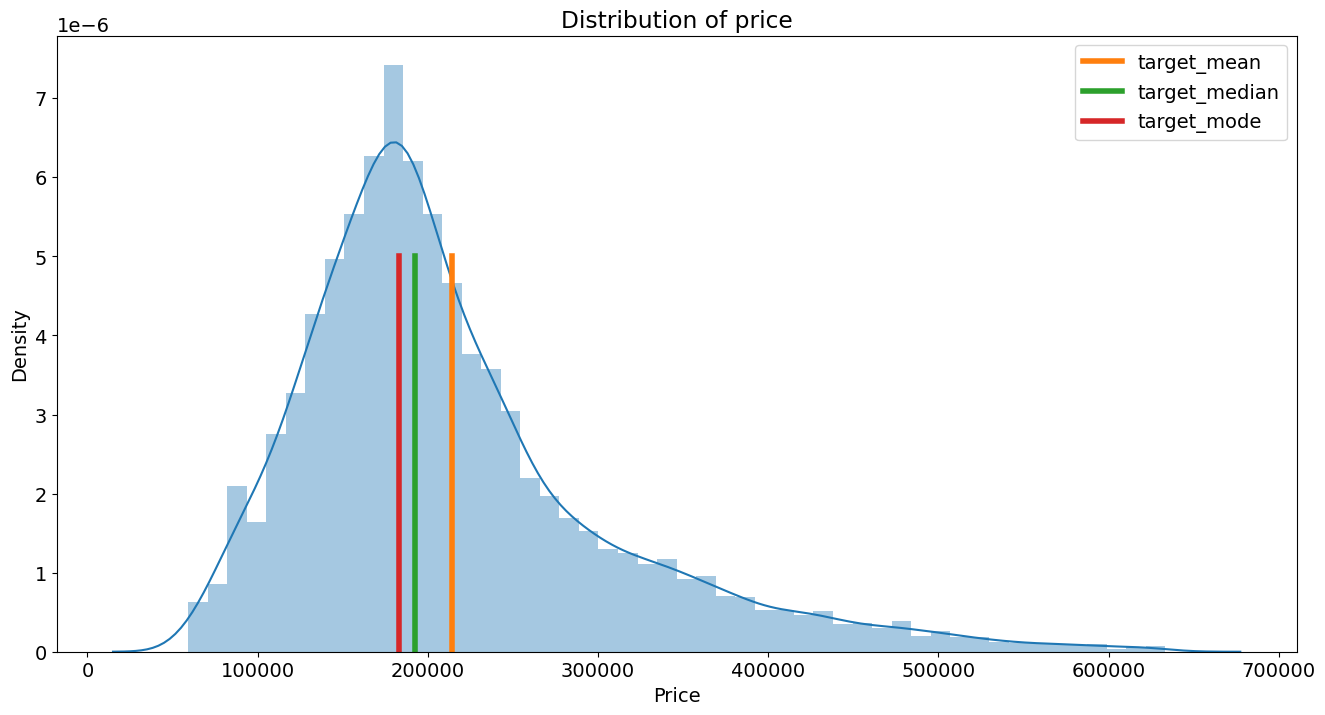

In [16]:
plt.figure(figsize = (16, 8))

sns.distplot(train['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='target_mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='target_median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='target_mode', linewidth=4)

plt.title('Distribution of price')
plt.legend()
plt.show()

Растянутось графика в право говорит о наличии небольшого количества дорогой недвижимости, что соответствует действительности. Поэтому выбросы не требуют коррекции. Среднее, медиана и мода расположены примерно посередине и близко друг от друга.

### Количественные признаки

In [17]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

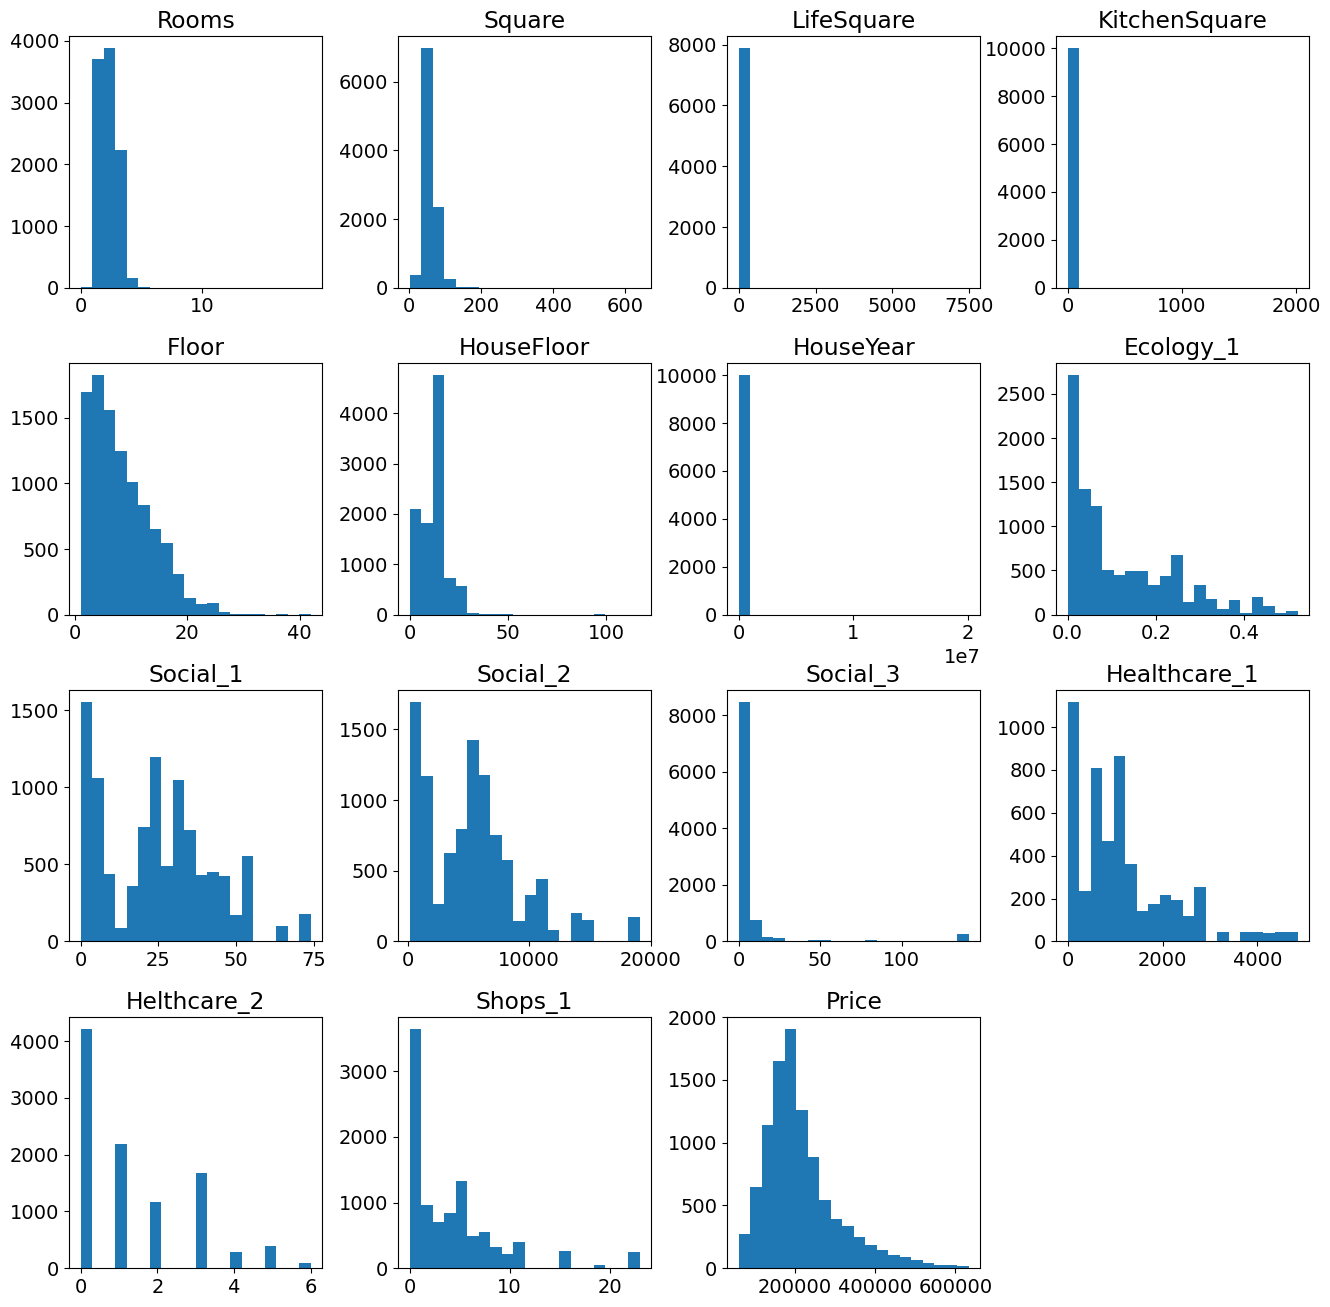

In [18]:
train.hist(figsize=(16,16), bins=20, grid=False)

Вывод основных статистических данных и визуализация количественных признаков говорят о необходимости более детально рассмотреть следующие признаки:
* количество комнат
* количество этажей
* год постройки
* площади

**Номинативные переменные**

In [19]:
train.select_dtypes(include=['object', 'category']).columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [21]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [22]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [23]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## Обработка выбросов

**Square**

In [24]:
train['Square'].sort_values(ascending=False)

6977    641.065186
4262    604.705994
4690    409.425171
1982    275.645294
1981    212.932358
           ...    
9294      2.954309
1608      2.596351
4853      2.377248
8283      1.988943
6392      1.136859
Name: Square, Length: 10000, dtype: float32

In [25]:
train['Square'].describe()

count    10000.000000
mean        56.315712
std         21.058718
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

<AxesSubplot:xlabel='Square'>

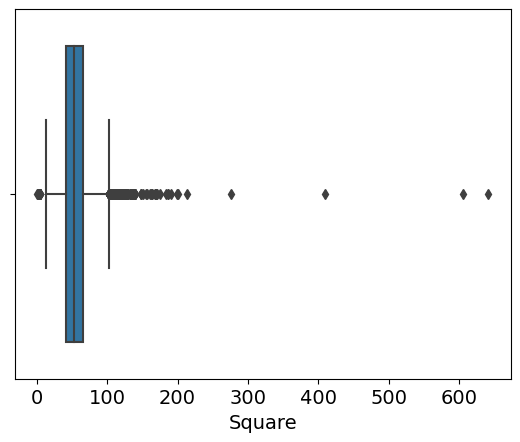

In [26]:
sns.boxplot(train['Square'])

In [27]:
train['Square'].quantile(.975), train['Square'].quantile(.025) 

(100.90624904632566, 32.10518369674683)

In [28]:
train[train['Square'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
1982,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.875000
4262,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.250000
4690,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
6977,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500
9910,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.500000


Очень большие площади для 1-2 комн. квартир и вообще для квартир. Ошибка или в размере площади или в количестве комнат. Площадь более 250 заменим на 250 и количество комнат поставим 6.

In [29]:
condition = (train['Square'] > 250) & (train['Rooms'] < 5)
train.loc[condition, 'Square'] = 250
train.loc[condition, 'Rooms'] = 6

In [30]:
train[train['Square'] < 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.093750
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.265625
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.593750
1891,13685,0,1.0,17.498543,13.446544,0.0,7,5.0,1961,0.319809,B,B,25,4756,16,2857.0,5,8,B,88871.750000
3166,15127,150,1.0,17.046188,20.036232,8.0,7,12.0,1982,0.300323,B,B,52,10311,6,NaN,1,9,B,74222.109375
3280,10527,27,1.0,4.380726,40.805836,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.718750
3413,9487,5,1.0,5.129221,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.406250
3794,523,101,1.0,18.509176,15.170851,3.0,5,5.0,1970,0.225825,A,B,41,6558,7,1548.0,3,2,B,115845.859375
4739,12676,81,3.0,13.784864,15.988890,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.804688
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312


Заменим очень маленькие значения площади на медиану.

In [31]:
condition = ((train['Square'] < 20) & (train['Rooms'] > 1)) | ((train['Rooms'] <= 1) & (train['Square'] < 16))
train.loc[condition, 'Square'] = train['Square'].median()

**KitchenSquare**

In [32]:
train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: KitchenSquare, dtype: int64

In [33]:
train['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.561113
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

<AxesSubplot:xlabel='KitchenSquare'>

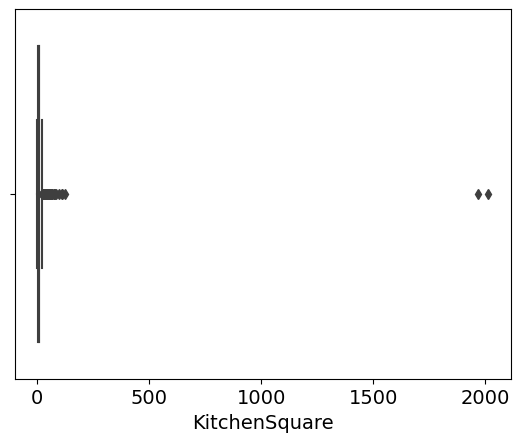

In [34]:
sns.boxplot(train.KitchenSquare)

Видим два выброса. А также есть большие для кухни площади и маленькие. Большие значения и выбросы заменим на медиану, а маленькие на 3.

In [35]:
train['KitchenSquare'].quantile(.975), train['KitchenSquare'].quantile(.025) 

(13.0, 0.0)

In [36]:
condition = (train['KitchenSquare'].isna()) | (train['KitchenSquare'] > train['KitchenSquare'].quantile(.975))
train.loc[condition, 'KitchenSquare'] = train['KitchenSquare'].median()
train.loc[train['KitchenSquare'] < 3, 'KitchenSquare' ] = 3

In [37]:
train['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**LifeSquare**

In [38]:
filtered_train = train[train['LifeSquare'].notna()]
filtered_train['LifeSquare'].sort_values(ascending=False)

4328    7480.592285
6977     638.163208
8437     461.463623
4690     410.639740
590      263.542023
           ...     
2887       1.049867
4853       0.873147
9602       0.795539
26         0.641822
6609       0.370619
Name: LifeSquare, Length: 7887, dtype: float32

In [39]:
train['LifeSquare'].describe()

count    7887.000000
mean       37.199596
std        86.241112
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

<AxesSubplot:xlabel='LifeSquare'>

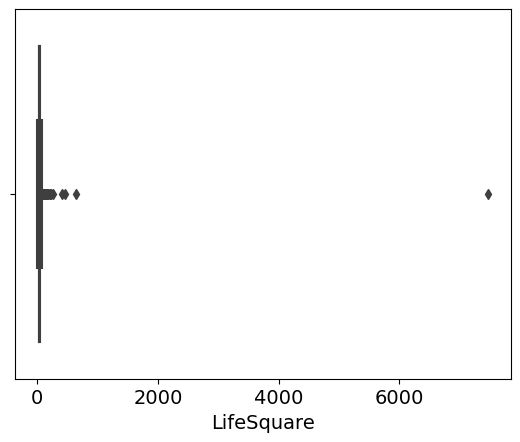

In [40]:
sns.boxplot(train.LifeSquare)

In [41]:
train['LifeSquare'].quantile(.975), train['LifeSquare'].quantile(.025) 

(80.7481, 5.9141297)

In [42]:
train[train['LifeSquare'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958870,0.641822,3.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.875000
95,4280,34,2.0,61.334969,4.091945,3.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.437500
134,12613,6,2.0,65.496674,5.589324,3.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.640625
158,16779,27,3.0,51.991066,4.896202,3.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.562500
160,3522,6,1.0,66.419838,3.987101,3.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.234375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,13583,27,2.0,58.943039,3.319486,3.0,11,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B,142789.953125
9813,2040,62,1.0,122.438148,5.751401,3.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.890625
9828,13630,24,3.0,127.141144,4.811405,3.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.937500
9888,6053,6,1.0,41.314774,5.005477,3.0,9,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515625


In [43]:
(train['LifeSquare'] > train['Square']).sum()

473

In [44]:
(train['LifeSquare'] > (train['Square'] - train['KitchenSquare'])).sum()

1063

Видим 2 выброса, а также значения, которые недопустимы. Заменим на разницу между общей площадью и площадью кухни.

In [45]:
condition = ((train['LifeSquare'] > train['Square']) & (train['LifeSquare'] > (train['Square'] - train['KitchenSquare'])))
train.loc[condition, 'LifeSquare'] = train['Square'] - train['KitchenSquare']

In [46]:
filtered_train = train[train['LifeSquare'].notna()]
filtered_train['LifeSquare'].sort_values(ascending=False)

6977    240.000000
4690    240.000000
1982    233.949310
1981    211.231125
9910    194.334534
           ...    
2887      1.049867
4853      0.873147
9602      0.795539
26        0.641822
6609      0.370619
Name: LifeSquare, Length: 7887, dtype: float32

Все равно остались недопустимо маленькие значения. Заменим их на разницу между общей площадью и площадью кухни.

In [47]:
train['LifeSquare'].quantile(.975), train['LifeSquare'].quantile(.025) 

(78.85968, 5.9141297)

In [48]:
train[train['LifeSquare'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958870,0.641822,3.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.875000
95,4280,34,2.0,61.334969,4.091945,3.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.437500
134,12613,6,2.0,65.496674,5.589324,3.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.640625
158,16779,27,3.0,51.991066,4.896202,3.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.562500
160,3522,6,1.0,66.419838,3.987101,3.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.234375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,13583,27,2.0,58.943039,3.319486,3.0,11,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B,142789.953125
9813,2040,62,1.0,122.438148,5.751401,3.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.890625
9828,13630,24,3.0,127.141144,4.811405,3.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.937500
9888,6053,6,1.0,41.314774,5.005477,3.0,9,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515625


In [49]:
condition = (train['LifeSquare'] < 10)
train.loc[condition, 'LifeSquare'] = train['Square'] - train['KitchenSquare']

In [50]:
filtered_train = train[train['LifeSquare'].notna()]
filtered_train['LifeSquare'].sort_values(ascending=False)

6977    240.000000
4690    240.000000
1982    233.949310
1981    211.231125
9910    194.334534
           ...    
7288     10.924281
6271     10.845368
4118     10.651456
5786     10.523869
3166      9.046188
Name: LifeSquare, Length: 7887, dtype: float32

**Rooms**

In [51]:
train['Rooms'].value_counts()

2.0     3878
1.0     3704
3.0     2235
4.0      150
5.0       18
0.0        8
6.0        4
10.0       2
19.0       1
Name: Rooms, dtype: int64

0 комнат не может быть. Небольшое количество квартир с комнатами больше 6, скорее всего это ошибка. Заменим столбцы, где 0 комнат на 1 и где больше 6 на медиану.

In [52]:
train['Rooms_outlier'] = 0
train.loc[(train['Rooms'] == 0) | (train['Rooms'] > 6), 'Rooms_outlier'] = 1
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.937500,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.437500,0
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.906250,0
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,0
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531250,0


In [53]:
train['Rooms_outlier'].value_counts()

0    9989
1      11
Name: Rooms_outlier, dtype: int64

In [54]:
train[train['Rooms_outlier'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
377,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.312500,1
1397,12638,27,0.0,138.427689,136.215500,3.0,4,3.0,2016,0.075424,...,B,11,3097,0,NaN,0,0,B,268394.750000,1
1454,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.617188,1
1981,7917,27,0.0,212.932358,211.231125,3.0,2,3.0,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,1
2269,7317,27,0.0,41.790882,NaN,3.0,13,0.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976562,1
3911,770,28,0.0,49.483501,NaN,3.0,16,0.0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.343750,1
4366,456,6,0.0,81.491447,NaN,3.0,4,0.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.796875,1
4853,3224,27,0.0,52.513309,49.513309,3.0,1,0.0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.945312,1
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.109375,1
8834,9443,27,0.0,87.762619,85.125473,3.0,5,15.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.921875,1


In [55]:
train.loc[train['Rooms'] == 0, 'Rooms'] = 1
train.loc[train['Rooms'] > 6, 'Rooms'] = train['Rooms'].median()

In [56]:
train['Rooms'].value_counts()

2.0    3881
1.0    3712
3.0    2235
4.0     150
5.0      18
6.0       4
Name: Rooms, dtype: int64

**HouseFloor, Floor**

In [57]:
train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [58]:
train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [59]:
(train['Floor'] > train['HouseFloor']).sum()

1825

Не может быть 0 этажей в доме. И не может квартира находится на большем этаже, чем общее количество этажей. Нулевой этаж заменим на медиану. Больший этаж заменим на случайное число в зависимости от общего количества этажей в доме. 

In [60]:
train['HouseFloor_outlier'] = 0
train.loc[train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train.loc[train['Floor'] > train['HouseFloor'], 'HouseFloor_outlier'] = 1


In [61]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = train['HouseFloor'].median()

In [62]:
floor_outliers = train.loc[train['Floor'] > train['HouseFloor']].index
floor_outliers 

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [63]:
train.loc[floor_outliers, 'Floor'] = train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x)) 

In [64]:
(train['Floor'] > train['HouseFloor']).sum()

0

**HouseYear**

In [65]:
train['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int32

Значения выше текущего года (2024) явно являются ошибками. Заменим на более реалистичные.

In [66]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2011
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [67]:
#train.loc[train['HouseYear'] > 2020, 'HouseYear'] = 2020

## Обработка пропусков

In [68]:
train.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [69]:
train[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981560,29.442751,6.0
1,65.683640,40.049541,8.0
2,44.947952,29.197611,3.0
3,53.352982,52.731510,9.0
4,39.649193,23.776169,7.0
5,80.384476,46.683720,12.0
6,62.254112,37.160378,7.0
7,80.312927,NaN,3.0
8,64.511436,NaN,3.0
9,46.461411,18.915552,8.0


**LifeSquare**

In [70]:
train['LifeSquare_nan'] = train['LifeSquare'].isna() * 1

condition = (train['LifeSquare'].isna()) & (~train['Square'].isna()) & (~train['KitchenSquare'].isna())
             
train.loc[condition, 'LifeSquare'] = train.loc[condition, 'Square'] - train.loc[condition, 'KitchenSquare']

**Healthcare_1**

In [71]:
train.drop('Healthcare_1', axis=1, inplace=True)

In [72]:
class DataPreprocessing:
    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
    def transform(self, X):
        # Square
        condition = (X['Square'] > 250) & (X['Rooms'] < 5)
        X.loc[condition, 'Square'] = 250
        X.loc[condition, 'Rooms'] = 6
        
        condition = ((X['Square'] < 16) & (X['Rooms'] > 1)) | ((X['Rooms'] <= 1) & (X['Square'] < 16))
        X.loc[condition, 'Square'] = self.medians['Square']
        
        # LifeSquare
        condition = (X['LifeSquare'] > X['Square']) & (X['LifeSquare'] > (X['Square'] - X['KitchenSquare'])) & (X['LifeSquare'] < 10)
        X.loc[condition, 'LifeSquare'] = X['Square'] - X['KitchenSquare']
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
                                                   
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
         
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
                                                   
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
                                                   
        # HouseYear
        current_year = datetime.now().year                                 
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
                                                   
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
                                                   
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
                                        
        X.fillna(self.medians, inplace=True)
        
        return X                  

## Построение новых признаков

In [73]:
binary_to_numbers = {'A': 0, 'B': 1}

train['Ecology_2'] = train['Ecology_2'].replace(binary_to_numbers)
train['Ecology_3'] = train['Ecology_3'].replace(binary_to_numbers)
train['Shops_2'] = train['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [74]:
district_size = train['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [75]:
train = train.merge(district_size, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.937500,0,0,0,22
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.437500,0,0,0,87
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.906250,0,0,0,174
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.234375,0,0,0,179
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531250,0,0,0,97


In [76]:
(train['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [77]:
train['IsDistrictLarge'] = (train['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [78]:
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [79]:
train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,1,184966.937500,0,0,0,22,0,207786.125000
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,16,1,300009.437500,0,0,0,87,0,300009.437500
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,1,3,1,220925.906250,0,0,0,174,1,263206.218750
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,5,1,175616.234375,0,0,0,179,1,166809.671875
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,1,150226.531250,0,0,0,97,0,158539.062500


In [80]:
class FeatureGenerator():
    
    def __init__(self):
        self.district_size = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
  
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IdDistrictlarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X = X.fillna(self.med_price_by_district_median)
        
        return X

## Отбор признаков

In [81]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [82]:
feature_names = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize', 'IsDistrictLarge', 
                     'MedPriceByDistrict']

target_name = 'Price'

## Разбиение на train и test

In [83]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [84]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df.shape, test_df.shape

((10000, 23), (5000, 22))

In [85]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [87]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [88]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [89]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum() 

(0, 0, 0)

## Построение модели

**Обучение**

In [90]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

**Оценка модели**

Train R2:	0.798
Test R2:	0.683


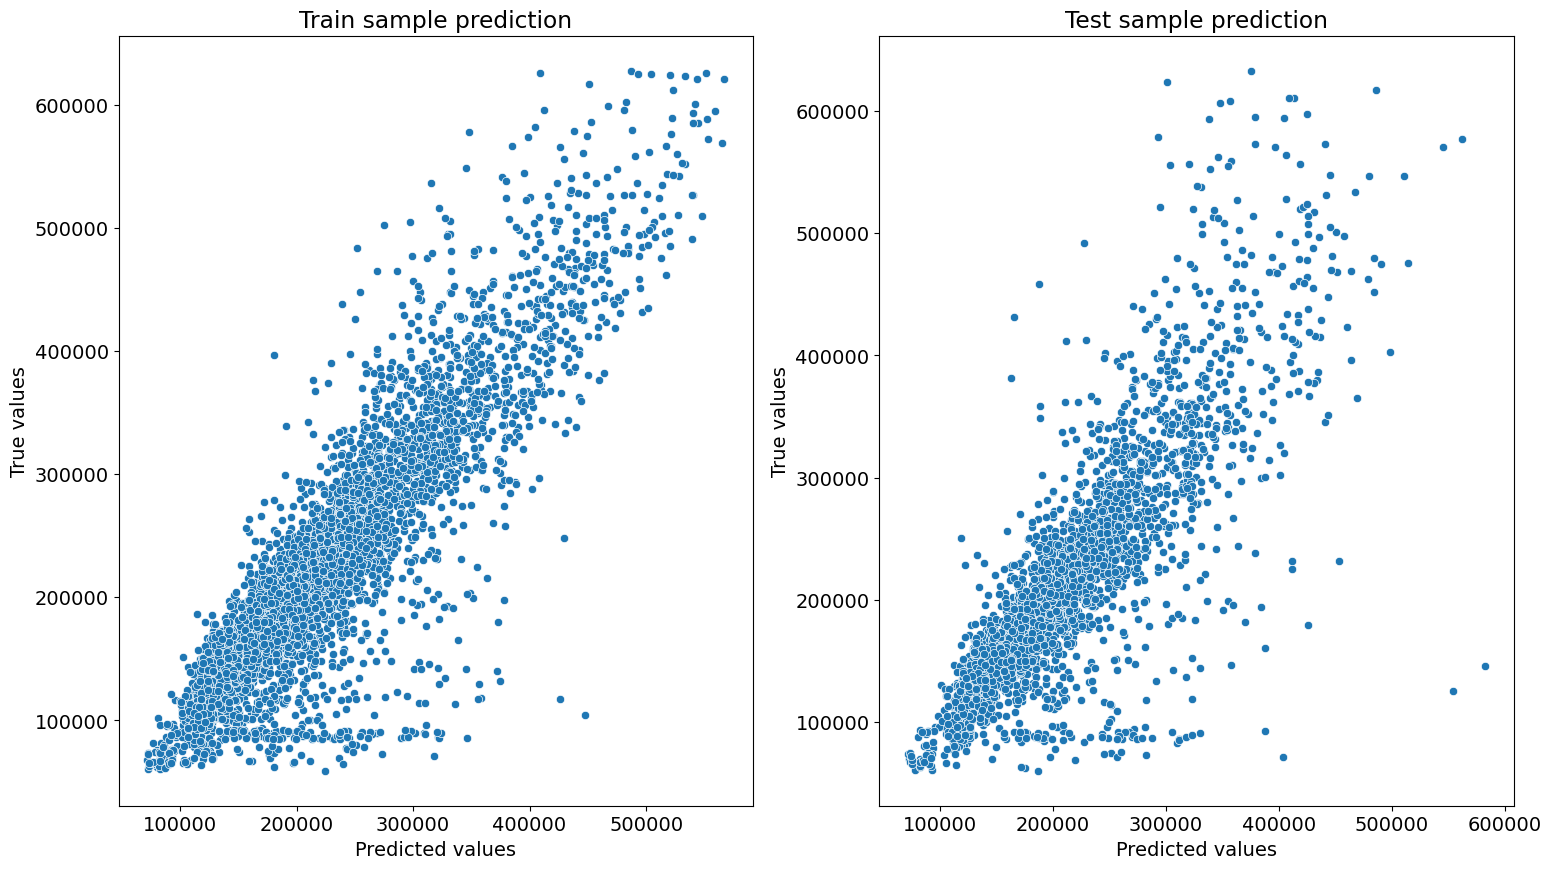

In [91]:
y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## Прогнозирование на тестовом датасете

In [92]:
predictions = xgb_model.predict(test_df)
predictions

array([163953.02, 265304.2 , 206184.48, ..., 319191.  , 185926.03,
       198688.44], dtype=float32)

In [93]:
results = pd.DataFrame({
    'Id': test_df['Id'],
    'PredictedPrice': predictions
})

results.to_csv('LAnisimova_predictions.csv', index=False)

In [94]:
with open('xgb_final_model', 'wb') as file:
    pickle.dump(xgb_model, file)

In [95]:
with open('preprocessor_model', 'wb') as file:
    pickle.dump(preprocessor, file)

In [96]:
# Random Forest Regressor
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
# rf_model.fit(X_train, y_train)

# Кросс-валидация
# cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score.mean()

# Важность признаков
# feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])
                                   
# feature_importances.sort_values(by='importance', ascending=False)

# Прогнозирование на тестовом датасете
# predictions = rf_model.predict(test_df)
# predictions